# Compare finite-infinite models

Join in one graph the plots for infinite and finite systems for all p

In [3]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
from isingchat import style
from isingchat.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


c:\users\mhjguillermo\pycharmprojects\doctorado\ising\isingchat\venv\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['interp', 'style']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Model
El modelo a utilizar es:
$$ \frac{J}{k_BT} = a_1 \left(\frac{1}{h_u(n_v,p,z=1,a=a_2)}\right) $$ 
con
$$ h_u(n_v,p,z,a) = \sum_{i=0}^{n_v-1} \frac{z^i}{(i+a)^p}  $$ 

In [4]:
def serie_divergente(n: int,p: float, z: float=1, a: float=1):
    res = 0
    for i in np.arange(0,n,1):
        res = res + z**i/((i+a)**p)
    return res


def model_function(x: float,p,coefs):
    """x = 1/nv"""
    a1,a2 = coefs
    return a1*(1/serie_divergente(x,p,z=1,a=a2))

## Get data

In [5]:
## get points for finite
# get points of Cv_mx
data_path = Path("../../data/regular/finite-size").resolve()
file_all_tc = 'finite_all_inv_Tc.csv'
df_inv_all_tc_finite = pd.read_csv(os.path.join(data_path,file_all_tc))
# get params of model
file_params = "finite_inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_3plus_params_curves_nv-12.csv"
df_params_finite = pd.read_csv(os.path.join(data_path,"Extrapolation",file_params),index_col=0)
# get extrapol val
file_extrapol_val = "finite_inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_3plus_extrapol_values_nv-12.csv"
df_extrapol_val_finite = pd.read_csv(os.path.join(data_path,"Extrapolation",file_extrapol_val),index_col=0)

## get points for infinite
# get points of Cv_mx
data_path = Path("../../data/regular/infinite-size").resolve()
file_all_tc = 'regular_all_inv_Tc.csv'
df_inv_all_tc_infinite = pd.read_csv(os.path.join(data_path,file_all_tc))
# get errors
file_all_tc_error = 'regular_all_inv_Tc_uncertainty.csv'
df_inv_all_tc_infinite_err = pd.read_csv(os.path.join(data_path,file_all_tc_error))
# get params of model
file_params = "inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_5plus_params_curves.csv"
df_params_infinite = pd.read_csv(os.path.join(data_path,"Extrapolation",file_params),index_col=0)
# get extrapol val
file_extrapol_val = "inv_Tc_vs_inv_nv_extrapol_gen_zeta_2_parms_with_nv_5plus_extrapol_values.csv"
df_extrapol_val_infinite = pd.read_csv(os.path.join(data_path,"Extrapolation",file_extrapol_val),index_col=0)


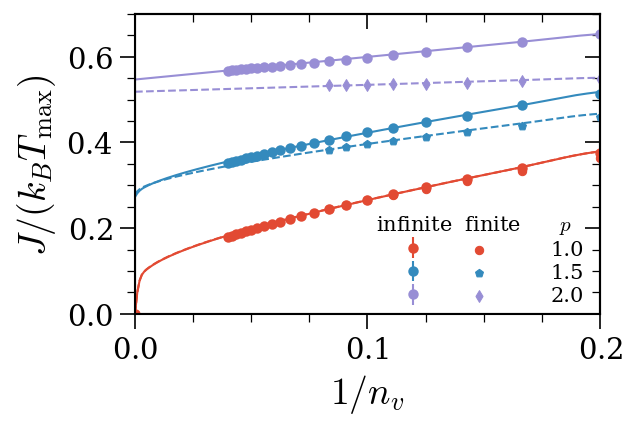

In [15]:
COLUMNS = ["P1.0",
           #"P1.05",
           #"P1.1",
#            "P1.2",
           #"P1.3",
           #"P1.4",
           "P1.5",
           #"P1.6",
           #"P1.7",
#            "P1.8",
           #"P1.9",
           "P2.0"]
epsilon = 0.001
# Load the default style.
style.use("default")
rcParams["text.usetex"] = False
markers = ["o",
#            "^",
#            "v",
#            "s",
#            "P",
#            "*",
           "p",
#            "h",
#            "D",
#            "X",
#            "8",
           "d"]
line_styles = ["solid",
               "dotted",
               "dashed",
               "dashdot",
               (0,(1,1)),
               (0,(5,1)),
               (0,(3,1,1,1)),
               (0,(3,1,1,1,1,1)), 
               (0,(3,1,3,1,1,1)),
               (0,(5,1,3,1,1,1)),
               (0,(6,1,4,1,2,1)),
               (0,(1,10)),
               (0,(5,10)),
               (0,(3,10,1,10))]

# fig1: Figure = pyplot.figure(figsize=(6, 4), dpi=150)
# fig1: Figure = pyplot.figure(figsize=(4, 4*(2/3)), dpi=150)
# grid_spec = GridSpec(1, 1)
fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

lines_finite = []
for index,column in enumerate(COLUMNS):
    # Get exponent
    p = float(column.replace("P",""))

    # Get inv_tc per col
    y_data_all = df_inv_all_tc_finite.loc[:, column]
    x_data_finite = np.array(df_inv_all_tc_finite.loc[y_data_all.notnull(), "1/nv"])
    y_data_finite = np.array(y_data_all.loc[y_data_all.notnull()])

    # add value at nv=infty
    if column == 'P1.0':
        x_data_finite = np.concatenate([x_data_finite,[0]])
        y_data_finite = np.concatenate([y_data_finite,[0]])
    
    line=ax.scatter(x_data_finite, y_data_finite, marker=markers[index], color='C'+str(index),label = '$p={}$'.format(p))

    # get coefs adjusted
    coefs = df_params_finite[column].values

    # get regular function
    x_extrapol = np.arange(1, 201, 1)
    y_extrapol = []

    for x_point in x_extrapol:
        if x_point < 5: 
            y_extrapol.insert(0,y_data_finite[x_point-1])
        else:
            y_extrapol.insert(0,model_function(x_point,p,coefs))
    x_extrapol = 1/x_extrapol
    x_extrapol = x_extrapol[::-1]
    y_extrapol = np.array(y_extrapol)
    # add the 1/nv = 0 value
    x_extrapol = np.insert(x_extrapol,0,0)
    y_extrapol = np.insert(y_extrapol,0,df_extrapol_val_finite.loc['infty'][column])
    # interpolate the points for regulirize the curve
    extrapol_funct = interp.UnivariateSpline(x_extrapol,
                            y_extrapol,
                            s=0, k=4)
    x_data_fine = np.linspace(0, 1, num=1024)
    y_data_fine = extrapol_funct(x_data_fine)
    ax.plot(x_data_fine, y_data_fine, lw=1,linestyle=line_styles[2], color='C'+str(index))
    lines_finite.append(line)

lines_infinite = []
for index,column in enumerate(COLUMNS):
    # Get exponent
    p = float(column.replace("P",""))    
    # infinite
    y_data_all = df_inv_all_tc_infinite.loc[:, column]
    y_data_all_err = df_inv_all_tc_infinite_err.loc[:,column]
    x_data = np.array(df_inv_all_tc_infinite.loc[y_data_all.notnull(), "1/nv"])
    y_data = np.array(y_data_all.loc[y_data_all.notnull()])
    y_data_err = np.array(y_data_all_err.loc[y_data_all_err.notnull()])

    # add value at nv=infty
    if column == 'P1.0':
        x_data = np.concatenate([x_data,[0]])
        y_data = np.concatenate([y_data,[0]])
        y_data_err = np.concatenate([y_data_err,[0]])

        
#     line=ax.scatter(x_data, y_data, marker=markers[index],facecolors='none', color='C'+str(index),label = '$p={}$'.format(p))
    line_err = ax.errorbar(x_data, y_data,yerr=y_data_err,fmt="o")

    # get coefs adjusted
    coefs = df_params_infinite[column].values

    # get regular function
    x_extrapol = np.arange(1, 201, 1)
    y_extrapol = []

    for x_point in x_extrapol:
        if x_point < 5: 
            y_extrapol.insert(0,y_data[x_point-1])
        else:
            y_extrapol.insert(0,model_function(x_point,p,coefs))
    x_extrapol = 1/x_extrapol
    x_extrapol = x_extrapol[::-1]
    y_extrapol = np.array(y_extrapol)
    # add the 1/nv = 0 value
    x_extrapol = np.insert(x_extrapol,0,0)
    y_extrapol = np.insert(y_extrapol,0,df_extrapol_val_infinite.loc['infty'][column])
    # interpolate the points for regulirize the curve
    extrapol_funct = interp.UnivariateSpline(x_extrapol,
                            y_extrapol,
                            s=0, k=4)
    x_data_fine = np.linspace(0, 1, num=1024)
    y_data_fine = extrapol_funct(x_data_fine)
    ax.plot(x_data_fine, y_data_fine, lw=1,linestyle=line_styles[0], color='C'+str(index))
    lines_infinite.append(line_err)


# Set major ticks for x axis
major_xticks = np.arange(0, 1, 0.1)

# I want minor ticks for x axis
minor_xticks = np.arange(0, 1, 0.025)

# Set major ticks for y axis
major_yticks = np.arange(0, 1, 0.2)

# I want minor ticks for y axis
minor_yticks = np.arange(0, 1, 0.05)

# ticks configuration
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.025))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

# labels configurations
ax.xaxis.label.set_size(18)
ax.set_xlabel(r"$1 / n_v$")

ax.yaxis.label.set_size(18)
ax.set_ylabel(r"$J / (k_B T_{\mathrm{max}})$")

ax.set_ylim(0, 0.7)
ax.set_xlim(0, 0.2)

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

# ax.legend(handles=[[lines_infinite[0],lines_finite[0]]],labels=['1.0'],
#           loc ="lower right",
#           fontsize = 10,
#           ncol = 2,
#           columnspacing = 0.2,
#           labelspacing = 0,
#           handletextpad=0,
#           frameon=False
#         )

ax.legend(handles=[(lines_infinite[0],lines_finite[0]),
                   (lines_infinite[1],lines_finite[1]),
                   (lines_infinite[2],lines_finite[2])],
          labels=['1.0','1.5','2.0'],
          title='infinite  finite      $p$    ',
          title_fontsize=10,
          handler_map = {tuple: matplotlib.legend_handler.HandlerTuple(None)},
          loc ="lower right",
          fontsize = 10,
          ncol = 1,
          handlelength = 6,
          columnspacing = 0.2,
          labelspacing = 0.2,
          handletextpad=2,
          borderaxespad=0,
          frameon=False
        )

# ax.text(0.119,0.21,'finite',fontsize=10)
# ax.text(0.16,0.21,'infinite',fontsize=10)

# ticks for the top axes
ax.tick_params(which='both',top=False,right=False)
ax.tick_params(which='major',length=7)
ax.tick_params(which='minor',length=4)

ax2 = ax.secondary_xaxis('top')
ax2.tick_params(which='both',direction='in',labeltop=False)
ax2.set_ticks(major_xticks)
ax2.set_ticks(minor_xticks, minor=True)
ax2.tick_params(which='major',length=7)
ax2.tick_params(which='minor',length=4)

# ticks for the right axes
ax3 = ax.secondary_yaxis('right')
ax3.tick_params(which='both',direction='in',labelright=False)
ax3.set_ticks(major_yticks)
ax3.set_ticks(minor_yticks,minor=True)
ax3.tick_params(which='major',length=7)
ax3.tick_params(which='minor',length=4)

#save plot
# plt.savefig('C://Users//MHJGuillermo//PycharmProjects//Doctorado//Ising//isingchat//venv//graphs//comparisons//regular_Tmax-vs-inv_nv_infinite-finiteAllEigs_v5.pdf')

pyplot.draw()
pyplot.show()